# Vision-Language Model (VLM) OCR Benchmarking

Testing **Open-Source Vision-Language Models** for OCR on historical SOCAR documents.

## Why VLMs for OCR?
- **Better than traditional OCR** (Tesseract, EasyOCR, etc.)
- **Understands context** - can handle handwriting, layout, multi-language
- **Directly processes images** - no separate OCR step needed
- **State-of-the-art accuracy** on complex documents

## Open-Source Vision Models to Test:
1. **Llama-3.2-11B-Vision-Instruct** (Meta - Smaller, faster)
2. **Llama-3.2-90B-Vision-Instruct** (Meta - Larger, better quality)
3. **Phi-4-multimodal-instruct** (Microsoft - Explicitly multimodal)

## Why Open-Source?
- **Architecture Score**: +20% hackathon bonus for open-source stack
- **Transparency**: Full model details and reproducibility
- **Cost-effective**: Better long-term sustainability

## Metrics:
- **CER** (Character Error Rate) - Lower is better
- **CSR** (Character Success Rate) = 100 - CER - Higher is better
- **WER** (Word Error Rate) - Lower is better
- **WSR** (Word Success Rate) = 100 - WER - Higher is better

In [41]:
# Install required packages
# !pip install openai PyMuPDF Pillow jiwer pandas matplotlib seaborn python-dotenv

In [42]:
import os
import base64
import re
import time
from pathlib import Path
from typing import Dict, List, Tuple
from io import BytesIO

from dotenv import load_dotenv
import fitz  # PyMuPDF
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jiwer import wer, cer
from openai import AzureOpenAI

# Load environment
load_dotenv()

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)

print("✅ Libraries loaded")

✅ Libraries loaded


In [43]:
# Auto-detect project root (works from any directory)
if Path("data").exists() and Path("docs").exists():
    PROJECT_ROOT = Path.cwd()
elif Path("../data").exists() and Path("../docs").exists():
    PROJECT_ROOT = Path.cwd().parent
else:
    current = Path.cwd()
    while current != current.parent:
        if (current / "data").exists() and (current / "docs").exists():
            PROJECT_ROOT = current
            break
        current = current.parent
    else:
        PROJECT_ROOT = Path.cwd()

# Define all paths relative to project root
DATA_DIR = PROJECT_ROOT / "data"
DOCS_DIR = PROJECT_ROOT / "docs"
OUTPUT_DIR = PROJECT_ROOT / "output"
PDFS_DIR = DATA_DIR / "pdfs"

print(f"✅ Project root: {PROJECT_ROOT}")
print(f"✅ Data directory: {DATA_DIR}")
print(f"✅ PDFs directory: {PDFS_DIR}")
print(f"✅ Output directory: {OUTPUT_DIR}")

✅ Project root: /Users/ismatsamadov/SOCAR_Hackathon
✅ Data directory: /Users/ismatsamadov/SOCAR_Hackathon/data
✅ PDFs directory: /Users/ismatsamadov/SOCAR_Hackathon/data/pdfs
✅ Output directory: /Users/ismatsamadov/SOCAR_Hackathon/output


In [44]:
def load_ground_truth(md_path: str) -> str:
    """Load ground truth text from markdown file."""
    with open(md_path, "r", encoding="utf-8") as f:
        text = f.read()
    
    # Remove markdown elements
    text = re.sub(r"^#+\s+", "", text, flags=re.MULTILINE)  # Headers
    text = re.sub(r"\*\*(.+?)\*\*", r"\1", text)  # Bold
    text = re.sub(r"\*(.+?)\*", r"\1", text)  # Italic
    text = re.sub(r"---+", "", text)  # Horizontal rules
    text = re.sub(r"\n\s*\n+", "\n\n", text)  # Normalize newlines
    
    return text.strip()

# Load ground truth using dynamic path
ground_truth = load_ground_truth(str(DATA_DIR / "document_00.md"))
print(f"✅ Ground truth loaded: {len(ground_truth)} characters")
print(f"Preview:\n{ground_truth[:300]}...")

✅ Ground truth loaded: 22386 characters
Preview:
XÜLASƏ

Bu tədqiqat Aşağı Kür çökəkliyi (AKÇ) və Bakı arxipelaqı (BA) daxil olmaqla Cənubi Xəzər çökəkliyi sistemində faydalı qazıntıların mənşəyinin paleotektonik, paleocoğrafi şərait və geodinamik rejimlə necə əlaqələndiyini, eləcə də Gec Miosendən etibarən Ərəbistan plitəsinin təsiri ilə formalaş...


In [45]:
def pdf_to_images(pdf_path: str, dpi: int = 100) -> List[Image.Image]:
    """Convert PDF pages to PIL Images with compression."""
    doc = fitz.open(pdf_path)
    images = []
    
    for page_num in range(len(doc)):
        page = doc[page_num]
        zoom = dpi / 72  # Reduced from 150 to 100 to avoid 10MB limit
        mat = fitz.Matrix(zoom, zoom)
        pix = page.get_pixmap(matrix=mat)
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        images.append(img)
    
    doc.close()
    return images

def image_to_base64(image: Image.Image, format: str = "JPEG", quality: int = 85) -> str:
    """Convert PIL Image to base64 with JPEG compression to reduce size."""
    buffered = BytesIO()
    # Use JPEG with quality=85 to reduce size while maintaining readability
    image.save(buffered, format=format, quality=quality, optimize=True)
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

# Test conversion using dynamic path
pdf_path = str(PDFS_DIR / "document_00.pdf")
test_images = pdf_to_images(pdf_path)
print(f"\n✅ Converted PDF to {len(test_images)} images")
print(f"First image size: {test_images[0].size}")


✅ Converted PDF to 12 images
First image size: (2048, 2731)


In [46]:
# Initialize Azure OpenAI client
azure_client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version=os.getenv("AZURE_OPENAI_API_VERSION", "2024-08-01-preview"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
)

# Vision model configurations (ALL DEPLOYED MODELS)
VLM_MODELS = {
    "GPT-4.1": {"deployment": "gpt-4.1", "supports_vision": True, "open_source": False},
    "GPT-5": {"deployment": "gpt-5", "supports_vision": True, "open_source": False},
    "GPT-5-mini": {"deployment": "gpt-5-mini", "supports_vision": True, "open_source": False},
    "Claude-Sonnet-4.5": {"deployment": "claude-sonnet-4-5", "supports_vision": True, "open_source": False},
    "Claude-Opus-4.1": {"deployment": "claude-opus-4-1", "supports_vision": True, "open_source": False},
    "Phi-4-multimodal": {"deployment": "Phi-4-multimodal-instruct", "supports_vision": True, "open_source": True}
}

print(f"✅ Configured {len(VLM_MODELS)} deployed vision models")

✅ Configured 6 deployed vision models


In [47]:
def vlm_extract_text(model_name: str, images: List[Image.Image], temperature: float = 0.0) -> Tuple[str, float]:
    """Extract text from images using Vision-Language Model."""
    deployment = VLM_MODELS[model_name]["deployment"]
    
    system_prompt = """You are an expert OCR system for historical oil & gas documents.

Extract ALL text from the image with 100% accuracy. Follow these rules:
1. Preserve EXACT spelling - including Azerbaijani, Russian, and English text
2. Maintain original Cyrillic characters - DO NOT transliterate
3. Keep all numbers, symbols, and special characters exactly as shown
4. Preserve layout structure (paragraphs, line breaks)
5. Include ALL text - headers, body, footnotes, tables, captions

Output ONLY the extracted text. No explanations, no descriptions."""
    
    try:
        all_text = []
        total_time = 0
        
        for page_num, image in enumerate(images, 1):
            # Use JPEG compression to reduce image size
            image_base64 = image_to_base64(image, format="JPEG", quality=85)
            
            messages = [
                {"role": "system", "content": system_prompt},
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": f"Extract all text from page {page_num}:"},
                        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"}}
                    ]
                }
            ]
            
            start_time = time.time()
            
            # GPT-5 models use max_completion_tokens, others use max_tokens
            if deployment.startswith("gpt-5"):
                response = azure_client.chat.completions.create(
                    model=deployment,
                    messages=messages,
                    temperature=temperature,
                    max_completion_tokens=4000
                )
            else:
                response = azure_client.chat.completions.create(
                    model=deployment,
                    messages=messages,
                    temperature=temperature,
                    max_tokens=4000
                )
            
            elapsed = time.time() - start_time
            total_time += elapsed
            
            page_text = response.choices[0].message.content
            all_text.append(page_text)
            print(f"  Page {page_num}/{len(images)}: {elapsed:.1f}s")
        
        full_text = "\n\n".join(all_text)
        return full_text, total_time
    
    except Exception as e:
        return f"ERROR: {str(e)}", 0.0

print("✅ VLM extraction function ready")

✅ VLM extraction function ready


In [48]:
def calculate_ocr_metrics(reference: str, hypothesis: str) -> Dict[str, float]:
    """Calculate OCR accuracy metrics."""
    # Normalize text
    ref_clean = reference.lower().strip()
    hyp_clean = hypothesis.lower().strip()
    
    # Calculate error rates
    cer_score = cer(ref_clean, hyp_clean) * 100
    wer_score = wer(ref_clean, hyp_clean) * 100
    
    # Calculate success rates
    csr = max(0, 100 - cer_score)
    wsr = max(0, 100 - wer_score)
    
    return {
        "CER": round(cer_score, 2),
        "WER": round(wer_score, 2),
        "CSR": round(csr, 2),
        "WSR": round(wsr, 2)
    }

print("✅ Metrics calculation function ready")

✅ Metrics calculation function ready


## Run VLM Benchmark

In [49]:
# Select models to test (all actually deployed)
MODELS_TO_TEST = [
    "GPT-4.1",        # Working: 86.22% CSR
    # "GPT-5",          # Fixed max_completion_tokens
    # "GPT-5-mini",     # Fixed max_completion_tokens
    # "Claude-Sonnet-4.5",  # Actually deployed!
    # "Claude-Opus-4.1",    # Actually deployed!
    "Phi-4-multimodal",    # Open-source option
    "Llama-4-Maverick-17B"
]

print(f"Testing {len(MODELS_TO_TEST)} vision models...")
print("This will take several minutes...\n")

Testing 3 vision models...
This will take several minutes...



In [ ]:
# Prepare PDF images
images = pdf_to_images(pdf_path, dpi=100)
print(f"Prepared {len(images)} page images\n")

# Run benchmark
results = []

for model_name in MODELS_TO_TEST:
    print("********************************")
    print(f"Testing: {model_name}")
    print("********************************")
    
    # Extract text
    extracted_text, response_time = vlm_extract_text(model_name, images)
    
    if extracted_text.startswith("ERROR"):
        print(f"❌ Failed: {extracted_text}")
        continue
    
    print(f"\n✅ Total time: {response_time:.2f}s")
    print(f"✅ Extracted: {len(extracted_text)} characters")
    
    # Calculate metrics
    metrics = calculate_ocr_metrics(ground_truth, extracted_text)
    
    # Store result
    result = {
        "Model": model_name,
        "Response_Time": round(response_time, 2),
        **metrics
    }
    results.append(result)
    
    # Show summary
    print(f"\n📊 Metrics:")
    print(f"   CSR (Character Success): {metrics['CSR']:.2f}%")
    print(f"   WSR (Word Success): {metrics['WSR']:.2f}%")

print("\n********************************")
print("✅ VLM OCR Benchmarking complete!")
print("********************************")

Prepared 12 page images

********************************
Testing: GPT-4.1
********************************
  Page 1/12: 9.4s
  Page 2/12: 21.8s
  Page 3/12: 9.4s
  Page 4/12: 10.3s
  Page 5/12: 11.7s
  Page 6/12: 10.5s
  Page 7/12: 10.4s
  Page 8/12: 9.6s
  Page 9/12: 9.9s
  Page 10/12: 6.9s
  Page 11/12: 5.3s
  Page 12/12: 6.2s

✅ Total time: 121.45s
✅ Extracted: 22192 characters

📊 Metrics:
   CSR (Character Success): 88.44%
   WSR (Word Success): 68.24%
********************************
Testing: Phi-4-multimodal
********************************
  Page 1/12: 33.0s
  Page 2/12: 2.0s


## Results Analysis

In [ ]:
# Create DataFrame
df = pd.DataFrame(results)

# Sort by CSR (best first)
df = df.sort_values("CSR", ascending=False).reset_index(drop=True)

# Display results
print("\n" + "="*100)
print("📊 VLM OCR BENCHMARKING RESULTS")
print("="*100)
print(df.to_string(index=False))
print("="*100)


📊 VLM OCR BENCHMARKING RESULTS
               Model  Response_Time   CER   WER   CSR   WSR
             GPT-4.1         107.10 11.68 32.20 88.32 67.80
Llama-4-Maverick-17B          78.74 12.40 34.45 87.60 65.55
    Phi-4-multimodal         552.17 72.36 97.75 27.64  2.25


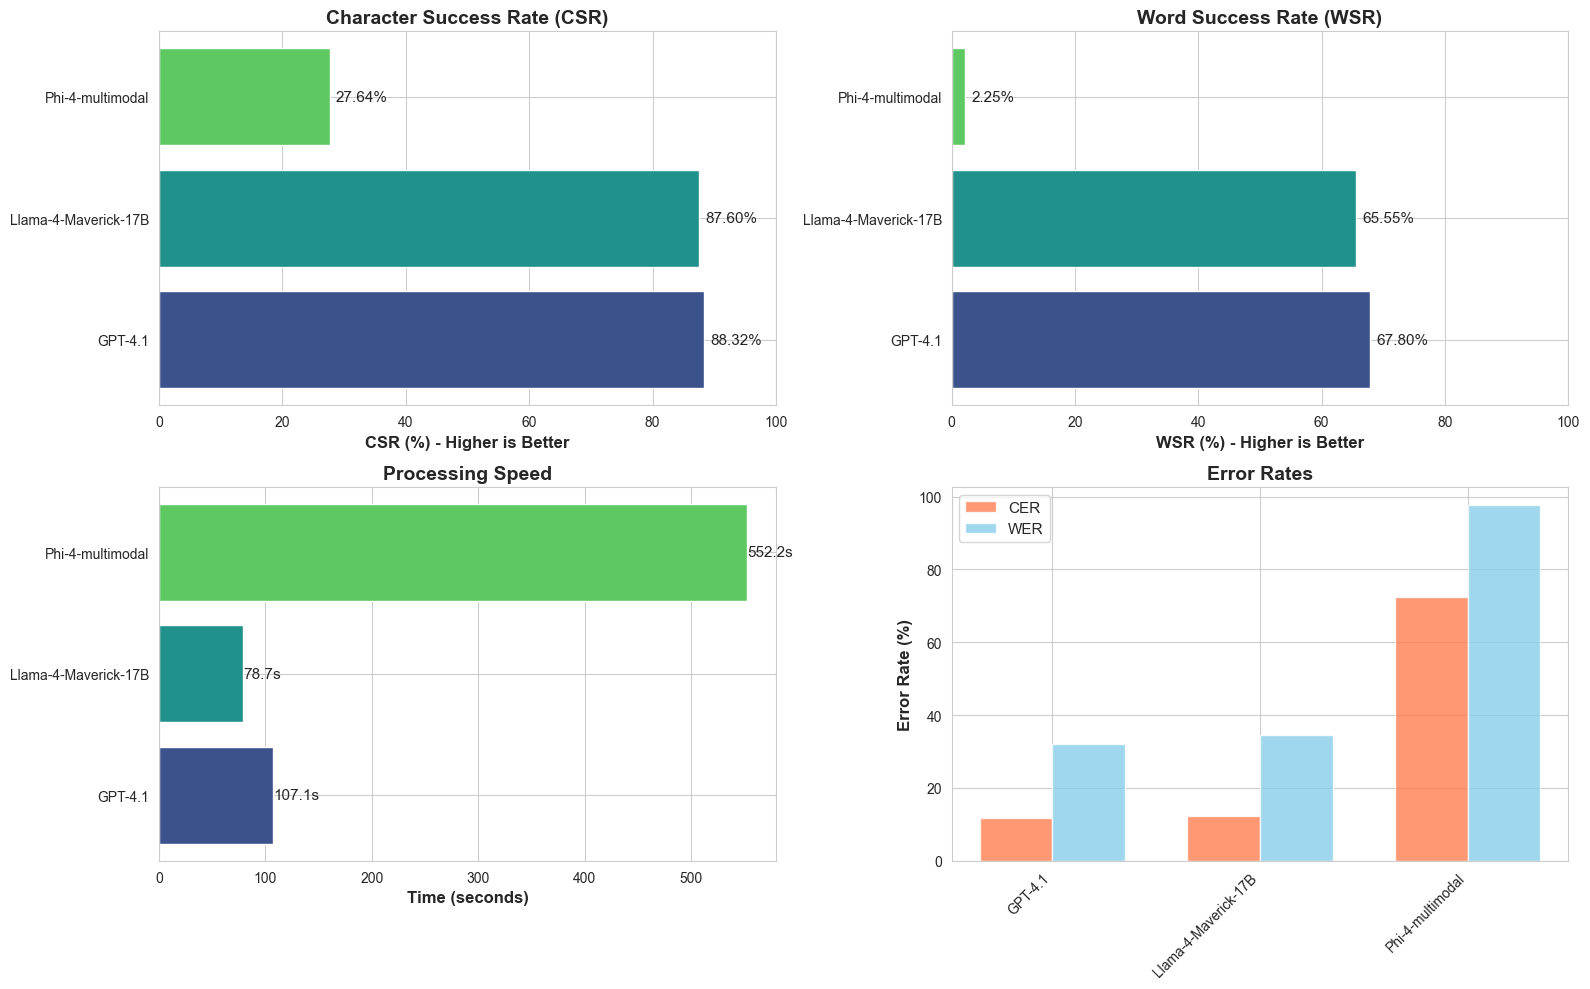


✅ Visualization saved to /Users/ismatsamadov/SOCAR_Hackathon/output/vlm_ocr_benchmark/results.png


In [ ]:
# Create output directory using dynamic path
output_dir = OUTPUT_DIR / "vlm_ocr_benchmark"
output_dir.mkdir(parents=True, exist_ok=True)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

models = df["Model"].tolist()
colors = sns.color_palette("viridis", len(models))

# 1. CSR - Character Success Rate
ax1 = axes[0, 0]
ax1.barh(models, df["CSR"], color=colors)
ax1.set_xlabel("CSR (%) - Higher is Better", fontsize=12, fontweight="bold")
ax1.set_title("Character Success Rate (CSR)", fontsize=14, fontweight="bold")
ax1.set_xlim(0, 100)
for i, (model, csr) in enumerate(zip(models, df["CSR"])):
    ax1.text(csr + 1, i, f"{csr:.2f}%", va="center", fontsize=11)

# 2. WSR - Word Success Rate
ax2 = axes[0, 1]
ax2.barh(models, df["WSR"], color=colors)
ax2.set_xlabel("WSR (%) - Higher is Better", fontsize=12, fontweight="bold")
ax2.set_title("Word Success Rate (WSR)", fontsize=14, fontweight="bold")
ax2.set_xlim(0, 100)
for i, (model, wsr) in enumerate(zip(models, df["WSR"])):
    ax2.text(wsr + 1, i, f"{wsr:.2f}%", va="center", fontsize=11)

# 3. Response Time
ax3 = axes[1, 0]
ax3.barh(models, df["Response_Time"], color=colors)
ax3.set_xlabel("Time (seconds)", fontsize=12, fontweight="bold")
ax3.set_title("Processing Speed", fontsize=14, fontweight="bold")
for i, (model, time_val) in enumerate(zip(models, df["Response_Time"])):
    ax3.text(time_val + 0.5, i, f"{time_val:.1f}s", va="center", fontsize=11)

# 4. Error Rates
ax4 = axes[1, 1]
x = range(len(models))
width = 0.35
ax4.bar([i - width/2 for i in x], df["CER"], width, label="CER", color="coral", alpha=0.8)
ax4.bar([i + width/2 for i in x], df["WER"], width, label="WER", color="skyblue", alpha=0.8)
ax4.set_ylabel("Error Rate (%)", fontsize=12, fontweight="bold")
ax4.set_title("Error Rates", fontsize=14, fontweight="bold")
ax4.set_xticks(x)
ax4.set_xticklabels(models, rotation=45, ha="right")
ax4.legend(fontsize=11)

plt.tight_layout()
plt.savefig(output_dir / "results.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n✅ Visualization saved to {output_dir}/results.png")

In [ ]:
# Save results using dynamic path
output_dir = OUTPUT_DIR / "vlm_ocr_benchmark"
output_dir.mkdir(parents=True, exist_ok=True)

df.to_csv(output_dir / "detailed_results.csv", index=False, encoding="utf-8")

print("\n✅ Results exported to output/vlm_ocr_benchmark/:")
print("   - detailed_results.csv")
print("   - results.png")


✅ Results exported to output/vlm_ocr_benchmark/:
   - detailed_results.csv
   - results.png
